In [246]:
import sys
import pandas as pd
import numpy as np
import re
import time
import os
import csv
import tabulate
import matplotlib.pyplot as plt

from sklearn import metrics

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn import svm, neighbors
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier #RandomizedLasso
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.semi_supervised import LabelPropagation
from sklearn.neural_network import MLPClassifier

In [139]:
PATH = '~/Documents/GitHub/march-madness/'
train = pd.read_csv('train_2010_2017.csv')

In [140]:
test = pd.read_csv('test_2018.csv')

In [141]:
## TAKE OUT ALL ADDED DATA 
takeout_vars = [u'PomeroyRank', u'Conf', u'AdjEM', u'AdjO',
       u'AdjD', u'AdjT', u'Luck', u'SOSAdjEM', u'OppO', u'OppD', u'NCSOSAdjEM',
       u'MooreRank', u'MooreSOS', u'MoorePR',u'OppPomeroyRank', u'OppConf', u'OppAdjEM', u'OppAdjO', u'OppAdjD',
       u'OppAdjT', u'OppLuck', u'OppSOSAdjEM', u'OppOppO', u'OppOppD',
       u'OppNCSOSAdjEM', u'OppMooreRank', u'OppW', u'OppL', u'OppT',
       u'OppMooreSOS', u'OppMoorePR',]
train = train.drop(takeout_vars, axis=1)
test = test.drop(takeout_vars, axis=1)

In [24]:
# from fragile families open source code 
def factorize(df):
    """Convert features of type 'object', e.g. 'string', to categorical
    variables or factors."""
    for col in df.columns:
        if df.loc[:,col].dtype == object:
            factors, values = pd.factorize(df[col])
            df.loc[:,col] = factors
    return df

DROP THE WLT COLUMNS TO AVOID THE ISSUE RN 

In [142]:
train = factorize(train)
test = factorize(test)
train = train.drop(['W', 'L', 'T'], axis=1)
test = test.drop(['W', 'L', 'T'], axis=1)

In [26]:
y_train = train['Outcome']
X_train = train.drop('Outcome', axis=1)

In [27]:
y_test = test['Outcome']
X_test = test.drop('Outcome', axis=1)

In [10]:
def plot_confusion(cm, y_labels, cmap=plt.cm.Blues, filename='untitled.png'):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.show()

In [329]:
def bin_test(x_data, x_labels, y_data, y_labels):
    starttime = time.time()

    # binary models
    models = ["BNB", "GNB", "LDA","SVM_L", "SVM_G", "5NN", "LR2", "P2", "SGD","ADA", "DT", "RF", "DPGMM", "ET", "GMM", "MLP"] #"SVM_L", "SVM_G", "P2", "DT",  "ADA_R", 
    clfs = [BernoulliNB(), \
            GaussianNB(), \
            LinearDiscriminantAnalysis(), \
            svm.SVC(kernel = 'linear', probability=True), \
            svm.SVC(kernel='rbf', probability=True), \
            neighbors.KNeighborsClassifier(n_neighbors=5), \
            LogisticRegression(), \
            Perceptron(penalty='l2',tol=None,max_iter=1000), \
            SGDClassifier(tol=0.0001, power_t=0.4, average=True), \
            AdaBoostClassifier(base_estimator=None, n_estimators=100), \
            DecisionTreeClassifier(), \
            RandomForestClassifier(oob_score=True),  \
            BayesianGaussianMixture(n_components=2,max_iter=1000, weight_concentration_prior_type='dirichlet_process', tol=0.0001), \
            ExtraTreesClassifier(bootstrap=True, oob_score=True, n_estimators=4), \
            GaussianMixture(n_components=2, tol=0.0001, max_iter=1000, n_init=2), \
            MLPClassifier(activation='relu', alpha=0.00001, max_iter=1000)]


    results = []

    for i in range(len(clfs)):
        print "model being tested: {0}".format(models[i])
        time_start = time.time()
        clf = clfs[i].fit(x_data, x_labels)
        predict = clf.predict(y_data)
        runtime = time.time() - time_start
        p = metrics.precision_score(y_labels, predict)
        r = metrics.recall_score(y_labels, predict, average="macro")
        f = metrics.f1_score(y_labels, predict)

        # find outliers
        # data = [('challengeID', y_data['challengeID'].values),
        #         ('predicted', predict),
        #         ('label', y_labels.values)]
        # labels_and_predicted = pd.DataFrame.from_items(data)
        # outliers = y_data.merge(labels_and_predicted, on='challengeID')
        # outliers = outliers[outliers['label'] != outliers['predicted']]

        # num_mislabeled = outliers.shape[0]
        # a_new = -1
        # p_new = -1
        # r_new = -1
        # f_new = -1

        # if (outliers['label'].unique().size > 1):
        #     # train separate model on outliers
        #     mislabeled_labels = outliers['label']
        #     mislabeled_samples = outliers.drop(['label', 'predicted'], axis=1)

        #     (train_vars,validate_vars,train_outcomes,validate_outcomes) = train_test_split(mislabeled_samples,mislabeled_labels,test_size=0.2)

        #     clf_new = clfs[i].fit(train_vars, train_outcomes)
        #     validate_predicted = clf_new.predict(validate_vars)

        #     # evaluate
        #     a_new = metrics.accuracy_score(validate_outcomes, validate_predicted)
        #     p_new = metrics.precision_score(validate_outcomes, validate_predicted)
        #     r_new = metrics.recall_score(validate_outcomes, validate_predicted, average="macro")
        #     f_new = metrics.f1_score(validate_outcomes, validate_predicted)

        # results.append([models[i], a, p, r, f, runtime, num_mislabeled, a_new, p_new, r_new, f_new])
        results.append([models[i], p, r, f, runtime])
        # create confusion matrix 
        cm = metrics.confusion_matrix(y_labels, predict)
        plot_confusion(cm, y_labels, filename='{0}_confusion.png'.format(models[i]))
    print tabulate.tabulate(results, headers=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','Runtime'])
    print "Binary test took {0} secs".format(time.time() - starttime)
    return pd.DataFrame(data=results)

model being tested: BNB
[[ 1 31]
 [ 3 29]]


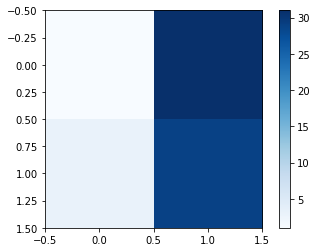

model being tested: GNB
[[22 10]
 [ 8 24]]


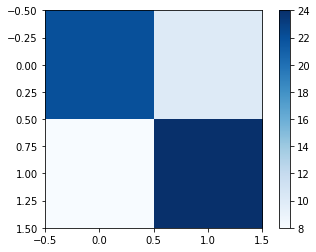

model being tested: LDA
[[24  8]
 [ 8 24]]


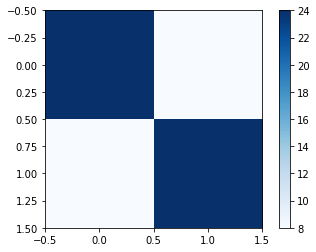

model being tested: SVM_L
[[26  6]
 [ 7 25]]


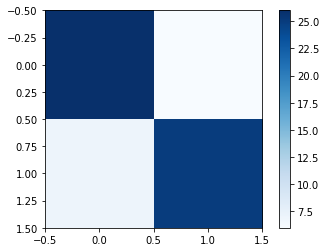

model being tested: SVM_G
[[32  0]
 [ 1 31]]


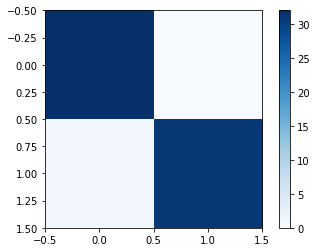

model being tested: 5NN
[[22 10]
 [11 21]]


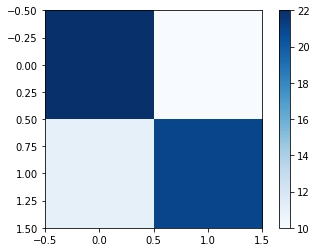

model being tested: LR2
[[24  8]
 [ 8 24]]


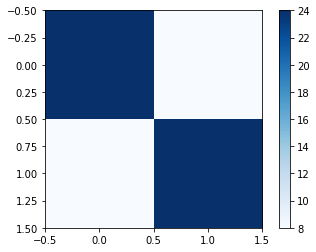

model being tested: P2
[[ 0 32]
 [ 0 32]]


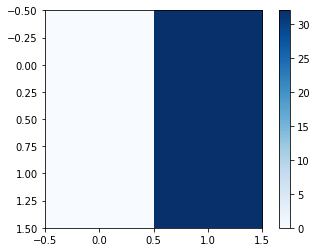

model being tested: SGD
[[21 11]
 [15 17]]


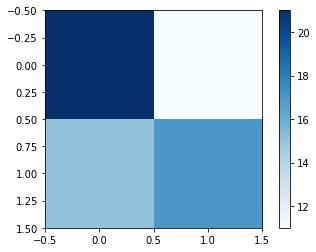

model being tested: ADA
[[26  6]
 [ 2 30]]


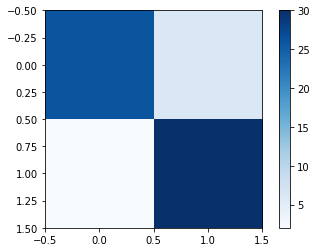

model being tested: DT
[[25  7]
 [ 8 24]]


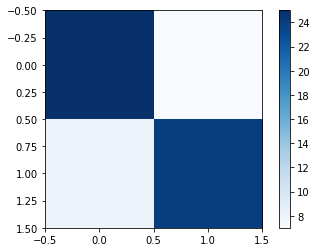

model being tested: RF
[[31  1]
 [ 5 27]]


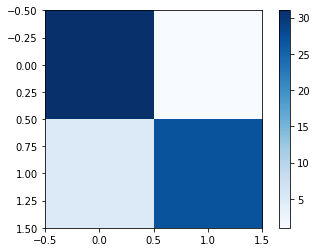

model being tested: DPGMM
[[14 18]
 [17 15]]


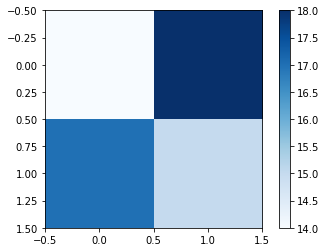

model being tested: ET
[[31  1]
 [ 5 27]]


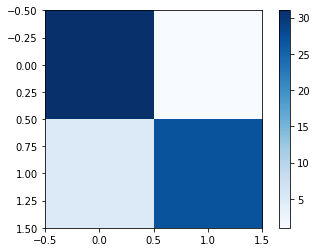

model being tested: GMM
[[14 18]
 [16 16]]


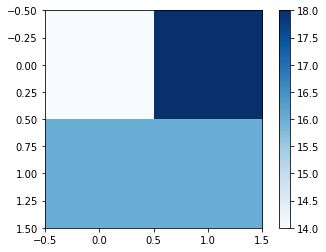

model being tested: MLP
[[16 16]
 [ 6 26]]


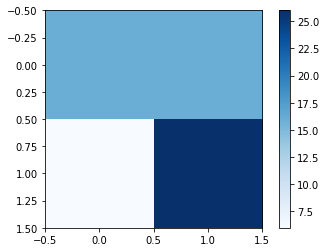

Model      Accuracy    Precision    Recall     F1 Score
-------  ----------  -----------  --------  -----------
BNB        0.483333     0.46875   0.630435   0.00422692
GNB        0.705882     0.71875   0.727273   0.00326991
LDA        0.75         0.75      0.75       0.00764489
SVM_L      0.806452     0.796875  0.793651  72.1751
SVM_G      1            0.984375  0.984127   0.70452
5NN        0.677419     0.671875  0.666667   0.00577497
LR2        0.75         0.75      0.75       0.118112
P2         0.5          0.5       0.666667   0.195099
SGD        0.607143     0.59375   0.566667   0.00906801
ADA        0.833333     0.875     0.882353   0.78537
DT         0.774194     0.765625  0.761905   0.052659
RF         0.964286     0.90625   0.9        0.0726418
DPGMM      0.454545     0.453125  0.461538   0.387438
ET         0.964286     0.90625   0.9        0.093528
GMM        0.470588     0.46875   0.484848   0.197131
MLP        0.619048     0.65625   0.702703   0.409345
Binary test took 

In [330]:
prediction_results = bin_test(X_train, y_train, X_test, y_test)

In [331]:
prediction_results.to_csv('~/Documents/GitHub/march-madness/prediction_results')
prediction_results = np.round(prediction_results, decimals=2)
print prediction_results.to_latex(index=False, header=True)

\begin{tabular}{lrrrr}
\toprule
     0 &     1 &     2 &     3 &      4 \\
\midrule
   BNB &  0.48 &  0.47 &  0.63 &   0.00 \\
   GNB &  0.71 &  0.72 &  0.73 &   0.00 \\
   LDA &  0.75 &  0.75 &  0.75 &   0.01 \\
 SVM\_L &  0.81 &  0.80 &  0.79 &  72.18 \\
 SVM\_G &  1.00 &  0.98 &  0.98 &   0.70 \\
   5NN &  0.68 &  0.67 &  0.67 &   0.01 \\
   LR2 &  0.75 &  0.75 &  0.75 &   0.12 \\
    P2 &  0.50 &  0.50 &  0.67 &   0.20 \\
   SGD &  0.61 &  0.59 &  0.57 &   0.01 \\
   ADA &  0.83 &  0.88 &  0.88 &   0.79 \\
    DT &  0.77 &  0.77 &  0.76 &   0.05 \\
    RF &  0.96 &  0.91 &  0.90 &   0.07 \\
 DPGMM &  0.45 &  0.45 &  0.46 &   0.39 \\
    ET &  0.96 &  0.91 &  0.90 &   0.09 \\
   GMM &  0.47 &  0.47 &  0.48 &   0.20 \\
   MLP &  0.62 &  0.66 &  0.70 &   0.41 \\
\bottomrule
\end{tabular}



# LOGISTIC REGRESSION

In [143]:
# get only 2018 data first, for test set 
test2018 = test[test['Season']==2018]
# get only round one data 
test2018 = test2018[test2018['Round']==1]

test2018_y = test2018['Outcome']
test2018_X = test2018.drop('Outcome', axis=1)

In [144]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predict = clf.predict(test2018_X)
a = metrics.accuracy_score(test2018_y, predict)
p = metrics.precision_score(test2018_y, predict)
r = metrics.recall_score(test2018_y, predict, average="macro")
f = metrics.f1_score(test2018_y, predict)
result = [a, p, r, f]
print result
weights = clf.coef_
idx = np.argsort(weights)
weights = weights[0,idx]
features = np.asarray(X_test.columns)
features = features[idx]
weights = pd.DataFrame(data=weights)
features = pd.DataFrame(data=features)
FW = pd.concat([features, weights])

[0.75, 0.75, 0.75, 0.75]


In [147]:
print predict

[1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0]


In [148]:
# normal LR 
clf = LogisticRegression()
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
a = metrics.accuracy_score(y_test, predict)
p = metrics.precision_score(y_test, predict)
r = metrics.recall_score(y_test, predict, average="macro")
f = metrics.f1_score(y_test, predict)
result = [a, p, r, f]
print result

[0.75, 0.75, 0.75, 0.75]


In [138]:
FW

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,AvgTO,AvgOppOR,OppAvgOppFGA,OppAvgOppTO,AvgOppDR,OppAvgOppStl,AvgDR,OppAvgOppPF,AvgFTA,AvgFGM3,...,OppAvgFTA,AvgOR,OppAvgDR,AvgOppPF,AvgOppStl,OppAvgOppDR,AvgOppTO,OppAvgOppOR,AvgOppFGA,OppAvgTO
0,-0.603565,-0.586931,-0.534002,-0.383374,-0.334232,-0.325594,-0.292977,-0.27718,-0.215777,-0.184571,...,0.195683,0.213631,0.255182,0.260072,0.355831,0.38928,0.392906,0.54438,0.570551,0.581317


# EXTRA TREES

In [105]:
clf = ExtraTreesClassifier(bootstrap=True, oob_score=True, n_estimators=4)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
a = metrics.accuracy_score(y_test, predict)
p = metrics.precision_score(y_test, predict)
r = metrics.recall_score(y_test, predict, average="macro")
f = metrics.f1_score(y_test, predict)
result = [a, p, r, f]
print result
weights = clf.feature_importances_
idx = np.argsort(weights)
weights = weights[idx]
features = np.asarray(X_test.columns)
features = features[idx]
weights = pd.DataFrame(data=weights)
features = pd.DataFrame(data=features)
FW = pd.concat([features, weights], axis=1)
FW.head

[0.953125, 0.967741935483871, 0.953125, 0.9523809523809523]


<bound method DataFrame.head of                  0         0
0         AvgOppPF  0.007266
1         AvgOppOR  0.007795
2       AvgOppFGA3  0.008757
3           AvgFTA  0.009051
4            AvgPF  0.010136
5           AvgAst  0.010194
6          AvgFGM3  0.010775
7       AvgOppFGM3  0.010833
8        OppTeamID  0.011448
9         OppAvgTO  0.011767
10    OppAvgOppFTA  0.012200
11       AvgOppAst  0.012291
12         AvgFGA3  0.012324
13          AvgFGA  0.012928
14      OppAvgFGA3  0.013042
15           AvgTO  0.013073
16    OppAvgOppStl  0.013146
17       OppAvgFGA  0.013220
18       OppAvgFTM  0.013641
19       AvgOppFGA  0.013717
20          Season  0.013919
21    OppAvgOppFGM  0.014210
22        OppAvgPF  0.014330
23     OppAvgOppOR  0.014421
24      OppAvgFGM3  0.014617
25        TeamSeed  0.014738
26    OppAvgOppFGA  0.014870
27       OppAvgFTA  0.014877
28    OppAvgPoints  0.015086
29          TeamID  0.015125
..             ...       ...
32           Round  0.015656
33       Av

In [63]:
predict

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# SVM, linear

In [80]:
clf = svm.SVC(kernel='linear',probability=True)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
a = metrics.accuracy_score(y_test, predict)
p = metrics.precision_score(y_test, predict)
r = metrics.recall_score(y_test, predict, average="macro")
f = metrics.f1_score(y_test, predict)
result = [a, p, r, f]
print result

[0.796875, 0.8064516129032258, 0.796875, 0.7936507936507936]


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,AvgDR,AvgOppOR,OppAvgOppStl,OppAvgOppFGA,AvgFGM3,OppAvgOppPF,AvgOppDR,AvgTO,AvgOppPoints,OppAvgBlk,...,OppAvgTO,AvgOppPF,OppAvgOppScore,OppAvgFTA,OppAvgFGM3,OppAvgOppDR,AvgOppFGA,AvgOppStl,OppAvgDR,OppAvgOppOR
0,-1.56464,-1.25544,-1.22545,-1.17343,-1.09013,-1.05811,-0.731946,-0.681813,-0.653998,-0.645044,...,0.689598,0.785429,0.798679,0.904337,1.00035,1.02655,1.17121,1.18369,1.23076,1.28845


In [81]:
weights = clf.coef_
idx = np.argsort(weights)
weights = weights[0,idx]
features = np.asarray(X_test.columns)
features = features[idx]
weights = pd.DataFrame(data=weights)
features = pd.DataFrame(data=features)
FW = pd.concat([features, weights])
FW.head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,AvgDR,AvgOppOR,OppAvgOppStl,OppAvgOppFGA,AvgFGM3,OppAvgOppPF,AvgOppDR,AvgTO,AvgOppPoints,OppAvgBlk,...,OppAvgTO,AvgOppPF,OppAvgOppScore,OppAvgFTA,OppAvgFGM3,OppAvgOppDR,AvgOppFGA,AvgOppStl,OppAvgDR,OppAvgOppOR
0,-1.56464,-1.25544,-1.22545,-1.17343,-1.09013,-1.05811,-0.731946,-0.681813,-0.653998,-0.645044,...,0.689598,0.785429,0.798679,0.904337,1.00035,1.02655,1.17121,1.18369,1.23076,1.28845


In [160]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

/Users/hanseulnam/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hanseulnam/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/hanseulnam/miniconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will 

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
DPGMM
DecisionTreeClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GMM
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultinomialNB
NuSVC
QuadraticDiscriminantAnalysis
RandomForestClassifier
SGDClassifier
SVC
VBGMM
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor
_DPGMMBase
_GMMBase


In [326]:
clf = SGDClassifier(tol=0.0001, power_t=0.4, average=True)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
p = metrics.precision_score(y_test, predict)
r = metrics.recall_score(y_test, predict, average="macro")
f = metrics.f1_score(y_test, predict)
result = [p, r, f]
print result

[0.6666666666666666, 0.59375, 0.4800000000000001]
